In [ ]:
from collections import defaultdict
import src.database.db_connection as db_connection
import src.database.db_methods as db_methods
import pandas as pd
from collections import Counter
from math import log2, sqrt
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, kruskal
from src.plot_generation import category_colors
import src.plot_generation as plot_generation

## Summary
In this notebook, we will analyze and visualize data from the channels, time_series, and videos datasets to uncover insights and trends. Below are the key areas we will focus on:

**1. Global Analysis Around Categories**

Making a general comparison of categories based on views, subscribers, number of videos, and their evolution over time to identify key trends and patterns.

**2. Community detection on categories**

Identifying clusters of frequently co-occurring categories to reveal content ecosystems and patterns of content diversification on YouTube.

**3. Design of a Channel Diversity Metric: A Quantitative Approach to Content Diversity**

Proposing and analyzing a metric to measure content diversity within channels, offering a new perspective on category dynamics and creative strategies.

**4. Comparing the evolution of channels across clusters using time series data**

Analyzing and comparing the growth dynamics of channels across different clusters over time using time series data to identify trends and differences in viewership and subscriber growth.

********************************************************************************************************************

# I. Exploratory Data Analysis

## i. Channels Data

### 0.Introduction

We'll start first by importing and cleaning our data.

In [ ]:
# MongoDB connection and information retrieval
channels_data_collection = db_connection.connect_to_mongodb("Channel Data")
channels_data = db_methods.retrieve_all_channels_from_mongodb(channels_data_collection)

Loading data...


In [ ]:
# Data cleaning procedure
def cleaning_pipeline(data):

    cleaned_data = data.copy()

        # delete the line with joint_data = NaN
    cleaned_data.drop(33540, inplace = True)

        # remplace name_cc that are NaN by 'unknown name'
    cleaned_data['name_cc'].fillna('unknown name', inplace=True)

        # drop channels with unknown category
    cleaned_data = cleaned_data[cleaned_data['category_cc'].notna()]

        # recreate the subscriber_rank_sb
    cleaned_data['subscriber_rank_sb'] = cleaned_data['subscribers_cc'].rank(ascending=False, method='dense')

        # subscriber_rank_sb type conversion
    cleaned_data['subscriber_rank_sb'] = cleaned_data['subscriber_rank_sb'].astype('int64')

        # date feature creation
    datetime_column = pd.to_datetime(cleaned_data['join_date'])
    cleaned_data['year'] = datetime_column.dt.year
    cleaned_data['month'] = datetime_column.dt.month
    cleaned_data['day'] = datetime_column.dt.day

    return cleaned_data

In [ ]:
channels = cleaning_pipeline(channels_data)

### 1. Channel Categories Distribution

To start, we visualize the distribution of YouTube channel categories to gain an overview of their relative proportions.

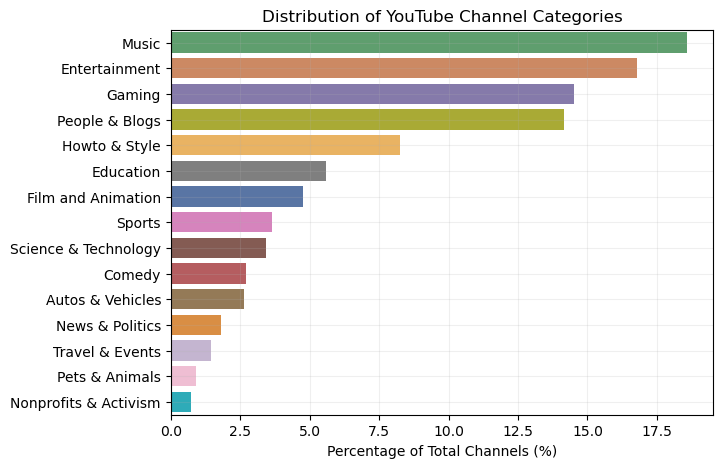

In [ ]:
plot_generation.plot_category_distribution(channels, category_colors)

Categories such as Nonprofits & Activism and Pets & Animals are more niche, resulting in fewer channels. On the other hand, Music, Entertainment, Gaming, and People & Blogs dominate with the highest number of YouTube channels.

To better understand the dominance of these categories, we calculate their representation among all YouTube channels:

In [ ]:
def get_cumulative_percentage_top_k(data, k):
    distribution = data['category_cc'].value_counts(normalize=True).sort_values(ascending=False) * 100
    df_dist = distribution.reset_index()
    df_dist.columns = ['category', 'percentage']
    cumulative_percentage = df_dist.head(k)['percentage'].sum()
    return cumulative_percentage

In [ ]:
# Results
top_k_cumulative_percentage = get_cumulative_percentage_top_k(channels, k=4)
print(top_k_cumulative_percentage.round(2), '%')

64.05 %


The four categories : **Music, Entertainment, Gaming and People & Blogs** represent **63%** of the total number of youtube channels.

### 2. Subscribers Categories Distribution

Then, let's visualize the distribution of subscribers across YouTube channel categories to explore how audiences are distributed.

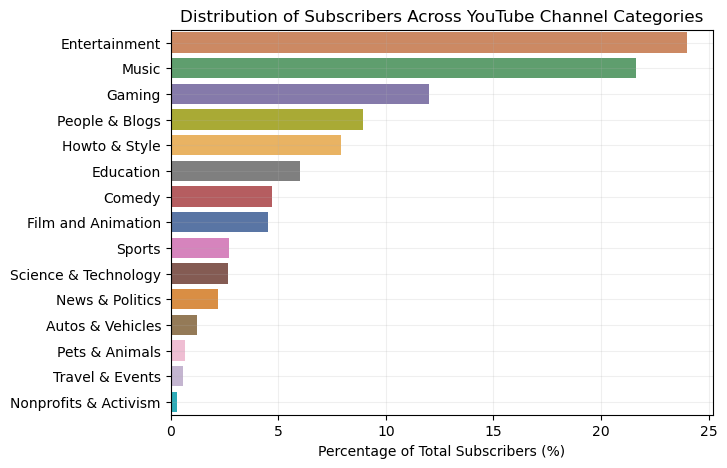

In [ ]:
plot_generation.plot_category_subscribers_distribution(channels, category_colors)

As expected, Entertainment, Music, Gaming, and People & Blogs also lead in this plot, as these categories have the highest number of channels and tend to attract the most viewers. In contrast, people are less likely to subscribe to niche content.

Now, let's take a closer look at the percentage representation of the top 4 categories.

In [ ]:
def get_cumulative_subscribers_percentage_top_k(data, k):
    total_number_of_subscribers = data['subscribers_cc'].sum()
    df_dist = data.groupby('category_cc')['subscribers_cc'].sum().reset_index().sort_values(ascending=False, by='subscribers_cc')
    df_dist.columns = ['category', 'subscribers']
    df_dist['subscribers'] = 100 * df_dist['subscribers'] / total_number_of_subscribers
    cumulative_percentage = df_dist.head(k)['subscribers'].sum()
    return cumulative_percentage

In [ ]:
# Results
top_k_cumulative_subscribers_percentage = get_cumulative_subscribers_percentage_top_k(channels, k=4)
print(top_k_cumulative_subscribers_percentage.round(2), '%')

66.55 %


The four same categories : **Music, Entertainment, Gaming and People & Blogs** have around **66%** of the total number of subscribers.

### 3. Videos Per Category

Let's visualize the average number of videos per channel for each category to understand content creation patterns.

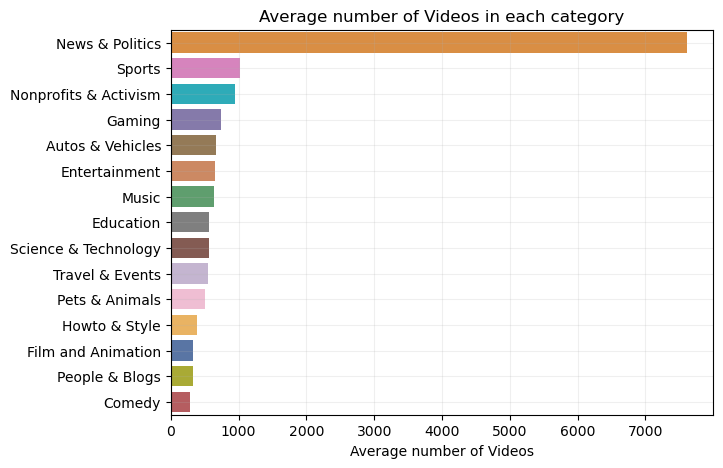

In [ ]:
plot_generation.plot_feature_by_category(channels, 'videos_cc', category_colors, agg_mode = 'mean')

News & Politics channels have the highest number of videos per channel by far, publishing numerous videos each day to cover global events.

Let's plot the total number of videos across all channels per category to compare the overall content volume.

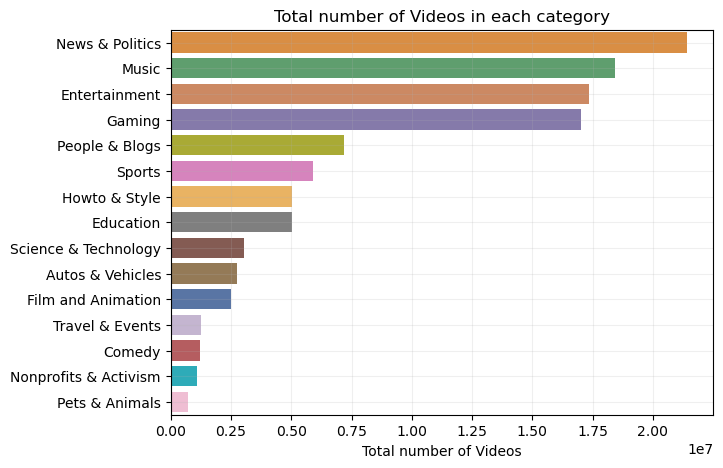

In [ ]:
plot_generation.plot_feature_by_category(channels, 'videos_cc', category_colors, agg_mode = 'total')

News & Politics remain in the lead despite their relatively low number of channels thanks to their large amount of videos, they are closely followed by categories like Entertainment, Music, and Gaming, which have a significantly larger number of channels.

### 4. Channel Creation Date per Category

Afterwards, we visualize the average join date for each category to compare the relative age of channels across different categories.

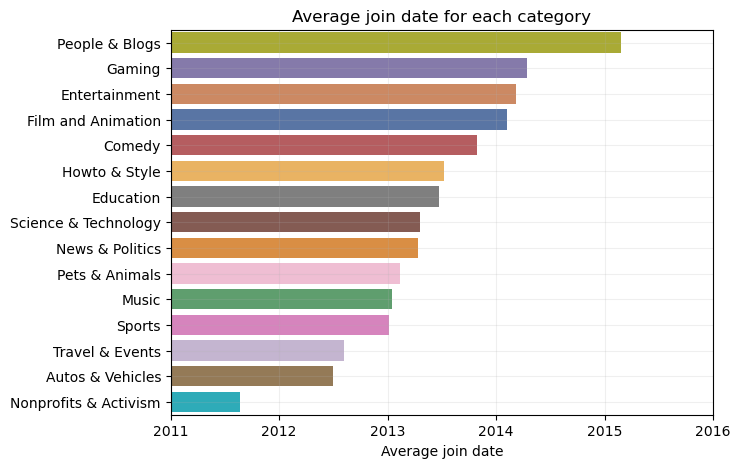

In [ ]:
plot_generation.plot_mean_join_date_by_category(channels, category_colors)

On average, the oldest channels are found in the Nonprofits & Activism and Auto & Vehicles categories, likely due to their long-established presence and stable audience. In contrast, the most recent channels, driven by trends and shifting interests, are found in People & Blogs and Gaming.

## ii. Time Series DataSet

We will now proceed with the analysis of the timeseries dataset.

### 0. Import and Cleaning procedures

We'll start first by importing and cleaning our data.

In [ ]:
# MongoDB connection
channels_weekly_time_series = db_connection.connect_to_mongodb("Channels Weekly Time Series")
time_series = db_methods.retrieve_all_channels_from_mongodb(channels_weekly_time_series)

Loading data...


In [ ]:
# Time series cleaning Procedure
def time_series_cleaning_pipeline(data):
    data = data.copy()
        # Remove the lines with unknown category
    data = data[data['category'].notna()]
        # turn the datatime column to a pd.datetime
    data['datetime'] = pd.to_datetime(data['datetime'])
    return data

In [ ]:
time_series = time_series_cleaning_pipeline(time_series)

### 1. Views per categories

The following analysis focuses on the number of views across different categories. We will examine how views are distributed among various categories, providing insights into which categories attract the most attention and engagement.

In [ ]:

df_channels_views = time_series.groupby(['channel', 'category'])[['delta_views', 'delta_videos']].sum().reset_index()
    # Rename columns.
df_channels_views = df_channels_views.rename(columns={'category': 'category_cc', 'delta_videos' : 'total_videos', 'delta_views' : 'total_views' })
    # Drops the lines with total_number of videos == 0
df_channels_views = df_channels_views[df_channels_views['total_videos'] != 0]
    # Creation of the column corresponding to the average number of views per videos.
df_channels_views['views'] = df_channels_views['total_views'] / df_channels_views['total_videos']


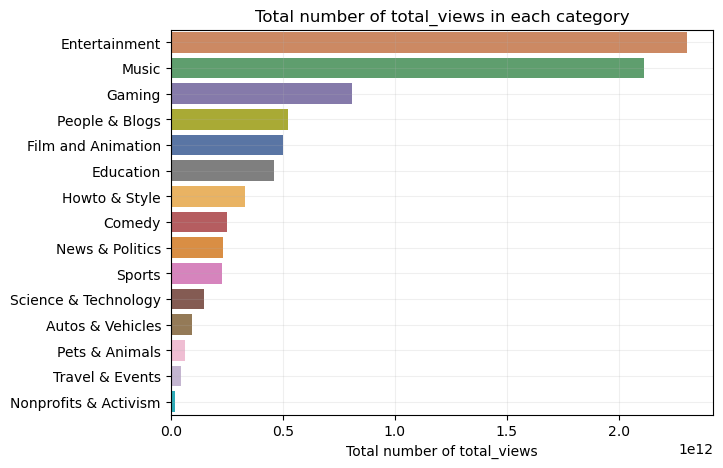

In [ ]:
plot_generation.plot_feature_by_category(df_channels_views, 'total_views', category_colors, agg_mode='total')

The categories that gather the most views are Entertainment and Music, as these categories are more general and trendy. In contrast, more niche categories like Autos & Vehicles, Pets & Animals, or Travel & Events are more specialized.

### 2. Ratio Views / Subscribers

The graph below examines the relationship between the number of views and the number of subscribers across different categories, using data from the channels and time_series datasets. This analysis aims to highlight how engagement varies by a ratio between videos & subscribers.

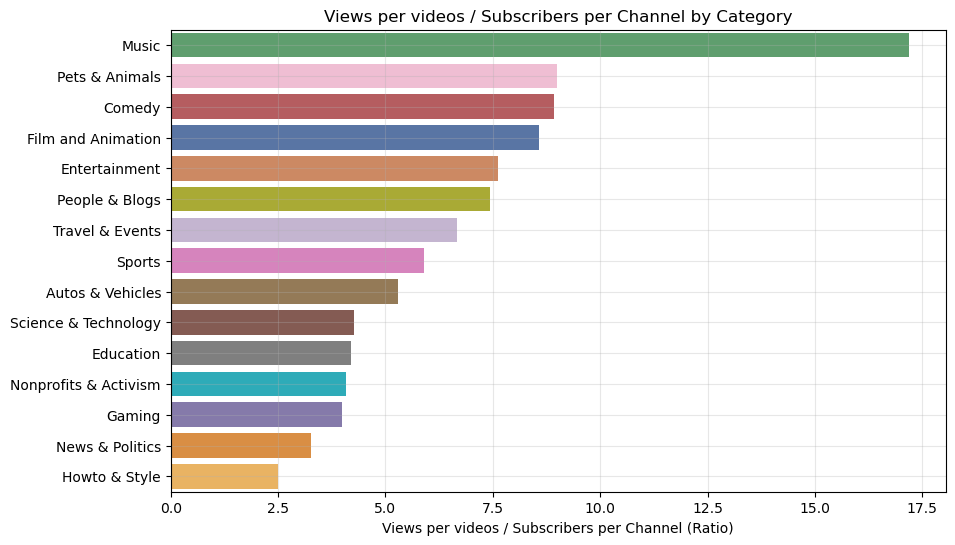

In [ ]:
df_channels_views = df_channels_views.merge(channels[['channel', 'subscribers_cc']], on='channel', how='left')
plot_generation.plot_ratio_views_subscribers(df_channels_views, category_colors)

Since the creation of recommendation algorithms, fewer people watch videos from their subscribers list and tend to click on videos shown on their home page. Categories like Music are recommended to more people, but users don’t subscribe as much. The same scenario applies to categories like Comedy or Film & Animation. In contrast, Gaming or News & Politics offer more specialized content and are recommended primarily to fans. This graph is strongly correlated to whether a channel targets a general audience.

### 3. Views and subscribers, time evolution

Let’s dive into the trends in views and subscribers over time to uncover interesting patterns and insights across different categories.

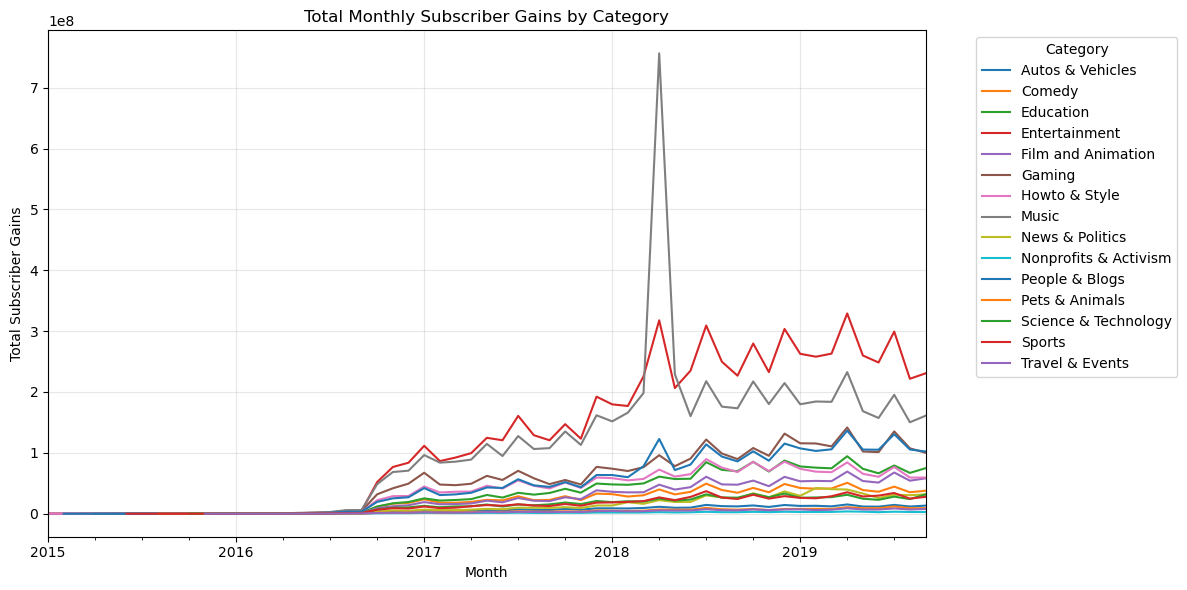

In [ ]:
plot_generation.plot_monthly_metric_by_category(time_series, metric='delta_subs')

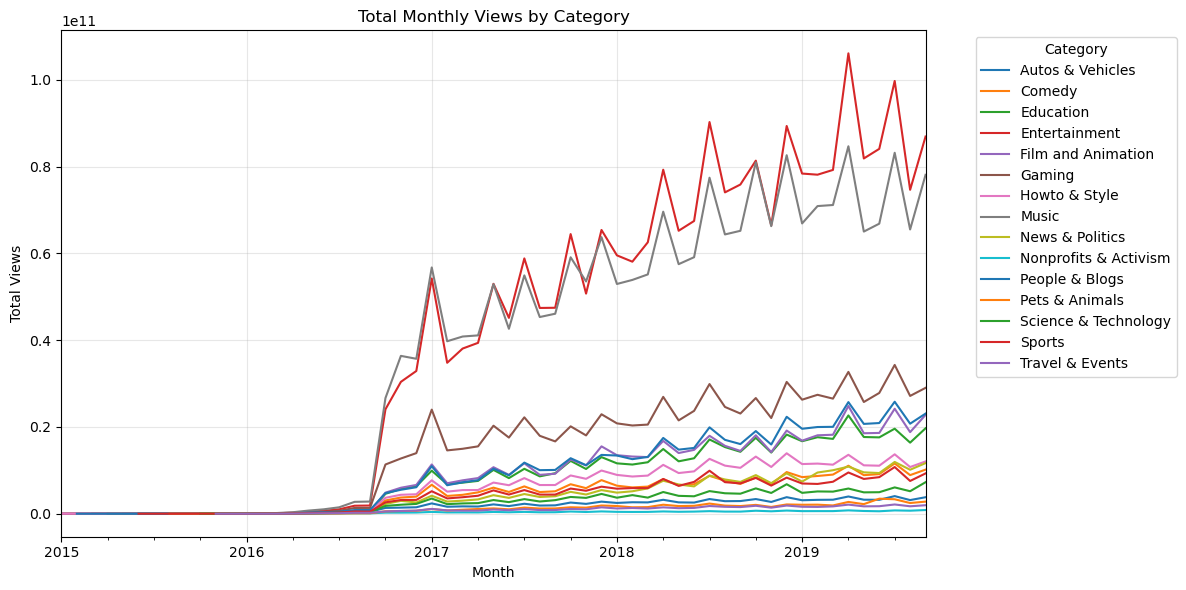

In [ ]:
plot_generation.plot_monthly_metric_by_category(time_series, metric='delta_views')

These two graphs show a cyclical evolution in the number of subscribers and views. This can be influenced by time periods when more people use YouTube, such as during holidays. Additionally, in winter, people tend to stay indoors and watch more content online.

We observe a spike in subscribers in March 2023 for the Music category, which could be due to a music artist going viral and gaining subscribers rapidly.

However, we lack sufficient data between 2015 and the end of 2016, which prevents us from fully analyzing the entire period from 2015 to 2019.

### 4. Number of new channels per month.

Let’s now look at the monthly evolution of newly created channels to explore trends across different categories.

<Figure size 1200x600 with 0 Axes>

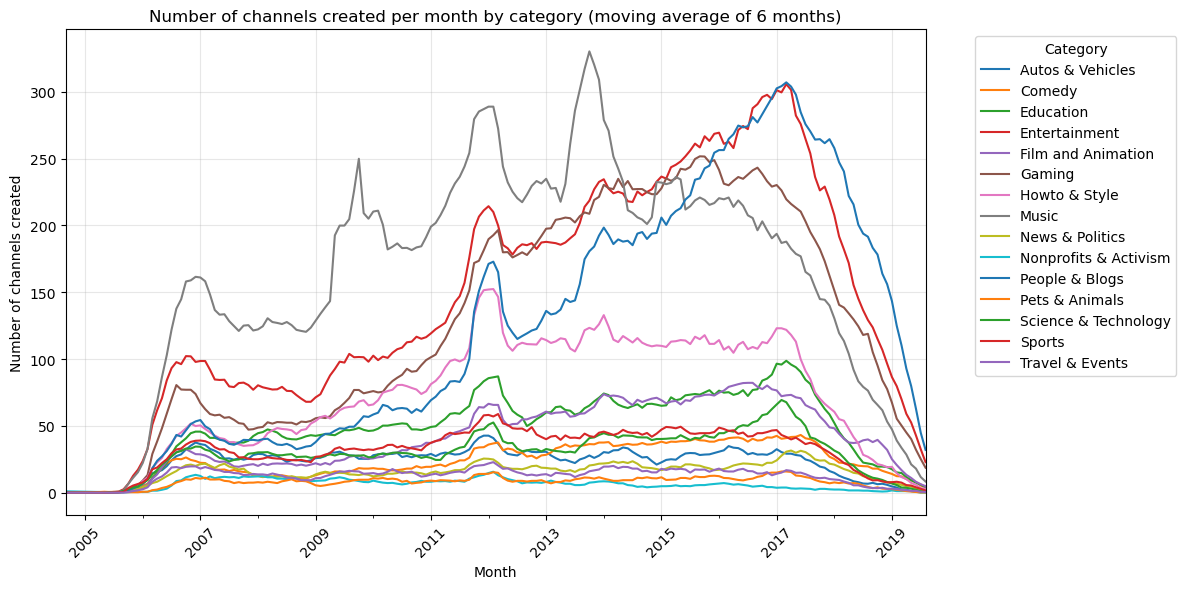

In [ ]:
plot_generation.plot_smoothed_monthly_channel_counts_by_category(channels, window=6)

This graph, which represents the number of channels created per month by category, reveals several interesting trends.

- First, it's important to note that our dataset represents videos from channels with more than 10k subscribers and more than 10 videos—channels that have essentially "made it". This is evident in the effects at the extremes of the graph. This limitation could introduce bias into our analysis.
- One notable trend is a general increase in all categories around 2012, likely due to a broader effect, possibly related to YouTube's growth or access at that time.
- Additionally, we observe that music channels were dominant until mid-2014, with peaks in channel creation driven by trends, as YouTube was primarily used to share music during this period. Few people were making a living on YouTube in other domains, which explains the lower creation rates in those categories.
- As the years go by, however, Entertainment and People & Blogs categories begin to emerge as YouTube staples, with more individuals becoming well-known and turning their channels into full-time careers, pushing these categories to the forefront by 2017.

# II. Community detection on categories

In the initial phase of our analysis, we will compute the co-occurrence matrix of categories across YouTube channels and visualize it using a heatmap and a network graph. The primary objective is to uncover relationships and overlaps between different types of content, which will allow us to gain insights into content diversification strategies and niche formation on the platform.

Understanding how categories co-occur will help us detect strong connections between content types (for instance: "Gaming" and "Music"), potentially indicating channels that cater to overlapping audiences. By visualizing these relationships as a network, we will highlight tightly connected clusters, revealing content ecosystems and emerging trends.

This analysis will also serve as a foundation for inspecting **channel diversity** in subsequent phases. By identifying which channels cover multiple categories, we can better understand the impact of content diversification on channel growth and audience engagement.

In [ ]:
# Connection to mongoDB
collection = db_connection.connect_to_mongodb(collection_name="Videos Data")

Connected to MongoDB at localhost:27017, Database: evollistable, Collection: Videos Data


In [ ]:
# Categories Retrival
channel_categories = db_methods.retrieve_categories_from_mongodb(collection)

## 1. Co-occurrence matrix computation

In [4]:
# Compute the co-occurrence matrix
def compute_co_occurrence(channel_categories_dict):
    """
    Computes the co-occurrence matrix for categories across all channels.

    Args:
    - channel_categories_dict: A dictionary where keys are channel_ids and values are lists of categories.

    Returns:
    - global_co_occurrence: A dictionary where keys are pairs of categories and values are their co-occurrence count.
    """
    global_co_occurrence = defaultdict(int)

    # Iterate through each channel and their associated categories
    for channel_id, categories in channel_categories_dict.items():
        for i in range(len(categories)):
            for j in range(i + 1, len(categories)):
                cat_1 = categories[i]
                cat_2 = categories[j]
                if len(cat_1)==0 or len(cat_2)==0:
                    continue
                # Increment the co-occurrence count for each category pair
                global_co_occurrence[(cat_1, cat_2)] += 1

    return global_co_occurrence

In [5]:
co_occurrence_matrix = compute_co_occurrence(channel_categories)

## 2. Heatmap
One way to visualize our co-occurrence matrix is by using a heatmap

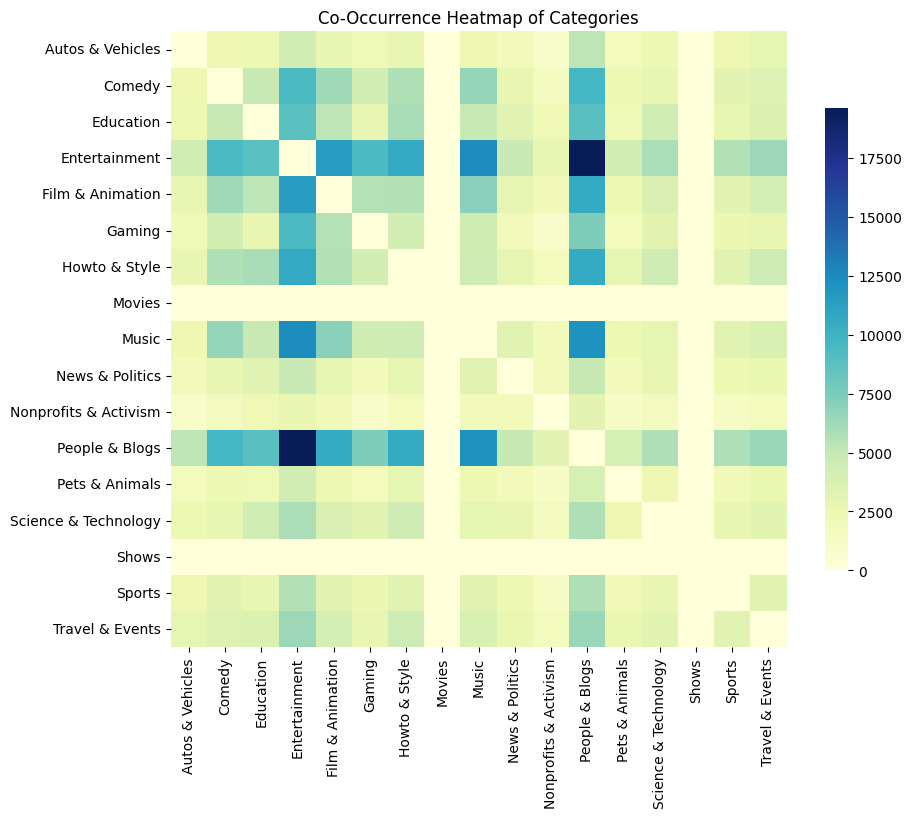

In [6]:
# Heatmap of the connections between categories
plot_generation.plot_co_occurrence_heatmap(co_occurrence_matrix)

**Observations**

The heatmap indicates that categories such as Entertainment and People & Blogs serve as central connectors among other categories. Additionally, it highlights frequent co-occurrences among categories like Gaming, Music, Film & Animation, and Comedy.

## 3. Co-occurrence Network

To better understand the relationships between different content categories, we analyze the co-occurrence patterns between them across channels. By visualizing these co-occurrences in a **network plot**, we can uncover clusters of categories that frequently appear together, providing insights into content strategies and audience interests. This visualization will help us identify key content synergies and how channels group their themes, ultimately shedding light on the dynamics of content diversification on the platform.

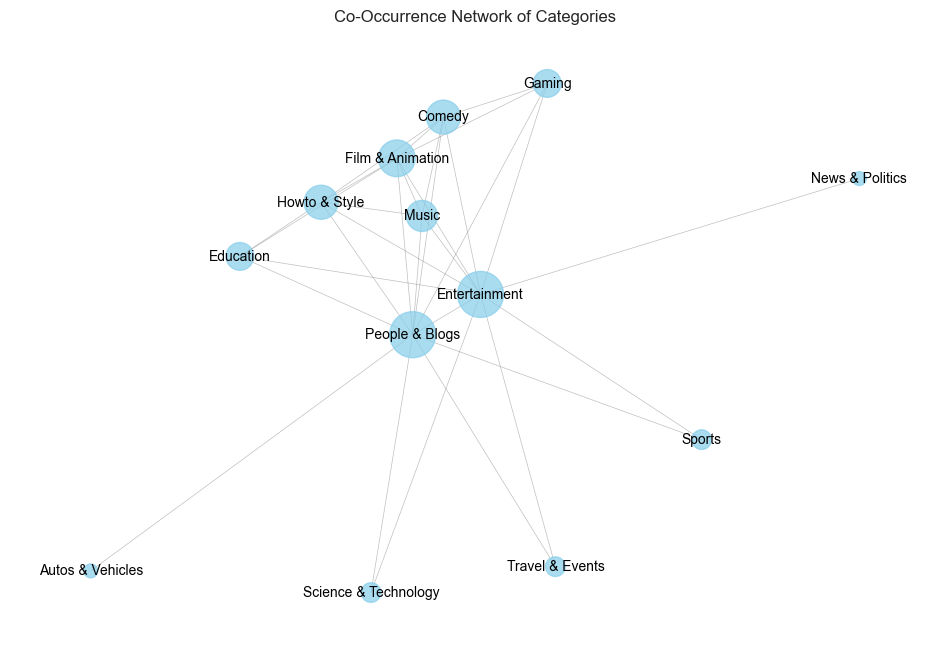

In [120]:
# Plot co-occurrence network
plot_generation.plot_co_occurrence_network(co_occurrence_matrix)

**Observations**

The central role of the "People & Blogs" and "Entertainment" categories suggests they serve as hubs that connect various other content genres on YouTube. These more general, cross-cutting categories likely overlap with and incorporate elements from more specialized categories.
The clustering of "Gaming", "Music", "Comedy", and "Film & Animation" indicates these genres tend to co-occur and may share common audiences or creative elements. This makes sense, as gaming, music, comedy, and animated content often intersect in the entertainment space.
Similarly, the clustering of "Education" and "Howto & Style" points to synergies between instructional/tutorial content and self-improvement/lifestyle content. These categories likely cater to viewers seeking knowledge and personal development.
The relative isolation of categories like "Sports", "Science & Technology", and "News & Politics" suggests they have more distinct, specialized content that does not overlap as readily with the broader entertainment and lifestyle-oriented categories. These genres likely appeal to more niche audiences.

After visualizing the co-occurrence network, we will apply clustering techniques to identify distinct groups of categories more clearly. This will help us pinpoint content clusters that frequently co-occur, revealing patterns in how channels organize their topics. To achieve this, we will use **Louvain's method**, a community detection algorithm that maximizes modularity to find optimal groupings. The method works by iteratively assigning nodes (categories) to communities in a way that increases the density of edges within communities while minimizing the density between them, providing clear, meaningful clusters.

Let's make things more interactive!

In [ ]:
# Interactive co-occurrence network
plot_generation.plot_interactive_co_occurrence_network(co_occurrence_matrix)

{'Entertainment': 1, 'Travel & Events': 1, 'People & Blogs': 1, 'Science & Technology': 1, 'News & Politics': 1, 'Sports': 1, 'Film & Animation': 2, 'Education': 0, 'Comedy': 2, 'Howto & Style': 0, 'Music': 2, 'Gaming': 2, 'Autos & Vehicles': 1}


As interactive plots do not render properly in the GitHub Notebook viewer, a screenshot of the interactive plot is provided below for easier viewing.

![Interactive Co-Occurrence Network of Categories](images/cooccurrence_network.png)

This plot reinforces the clusters identified in the previous visualization. However, it also highlights a limitation of Louvain's algorithm: it fails to recognize isolated categories as distinct clusters. Instead, these categories are often grouped with others, despite not sharing significant co-occurrence relationships. This issue arises because Louvain's method focuses on maximizing modularity, which can sometimes lead to less accurate representations of small or isolated communities that lack strong connections. To address this, additional refinement techniques or alternative community detection algorithms might be necessary to better capture these isolated categories.

# II. Design of a Channel Diversity Metric: A Quantitative Approach to Content Diversity

We want to evaluate the diversity of a channel based not only on the distribution of categories it publishes but also on the relatedness of those categories. Specifically, a channel that publishes content in categories that rarely co-occur (categories that are less related) should be considered more diverse than one that publishes content in closely related categories.

### i. Entropy: Measuring Category Distribution

The entropy term captures the **spread** of content across different categories in a channel. If a channel focuses on a narrow set of categories, entropy will be low, while a more balanced distribution of content across categories will yield higher entropy. Formally, entropy is calculated as:

$$
H = - \sum_{i=1}^{n} p_i \log(p_i)
$$

where $(p_i)$ is the proportion of content in category $(i)$ (estimated directly from the channel's category distribution), and $(n)$ is the total number of unique categories within the channel. A higher value of entropy indicates that the channel is more diverse in terms of the variety of topics it covers.

### ii. Normalized Mutual Information (NMI): Adjusting for Category Relationships

While entropy accounts for the spread of content, it does not capture how the categories are related. Channels that use categories with **high co-occurrence** may appear diverse at first glance, but in reality, they may be focusing on overlapping topics. To account for this, we incorporate **Normalized Mutual Information (NMI)**.

The NMI between two categories $(i)$ and $(j)$ is given by:

$$
\text{NMI}(i,j) = \frac{I(i,j)}{\max(H(i), H(j))}
$$

where $(I(i,j))$ is the **mutual information** between categories $(i)$ and $(j)$, and $(H(i))$, $(H(j))$ are the individual entropies of the categories. 

The mutual information is computed using the global co-occurrence matrix of categories across all channels:

$$
I(i,j) = p_{ij} \log \left( \frac{p_{ij}}{p_i^{\text{global}} p_j^{\text{global}}} \right)
$$

where:
- $(p_{ij})$ is the probability of categories $(i)$ and $(j)$ co-occurring across all channels.
- $(p_i^{\text{global}})$ and $(p_j^{\text{global}})$ are the global marginal probabilities of categories $(i)$ and $(j)$, respectively.

If two categories often co-occur, their NMI will be high, suggesting they are not independent, and thus the diversity score is penalized for such overlap.

### iii. The Full Diversity Metric

The final **Channel Diversity Metric** is computed as:

$$
\text{Channel Diversity} = \frac{- \sum_{i\neq j} p_i \log(p_i) \cdot (1 - \text{NMI}(i,j))}{\log(n)}
$$

This formula combines the entropy term, which encourages a broad distribution of categories, with the NMI adjustment, which penalizes the use of highly related categories. The division by $(log(n))$ normalizes the score, ensuring comparability across channels with different numbers of categories.

In [9]:
def calculate_diversity(channel_cats, co_matrix, unique_categories):
    """
    Calculate the diversity score of a channel based on the co-occurrence matrix and categories used by the channel.

    Args:
    - channel_cats: List of categories for the given channel (with redundancy).
    - co_matrix: The global co-occurrence matrix as a dictionary.
    - unique_categories: List of all unique categories globally.

    Returns:
    - Diversity score for the channel.
    """

    # Step 1: Calculate global probabilities
    total_co = sum(co_matrix.values())
    p_ij = {}
    p_global = {}

    # Compute global marginal probabilities and joint probabilities
    for cat in unique_categories:
        p_global[cat] = sum(co_matrix.get((cat, other), 0) for other in unique_categories) / total_co

    for (cat1, cat2), co_count in co_matrix.items():
        p_ij[(cat1, cat2)] = co_count / total_co

    # Step 2: Channel-specific calculations
    n = len(set(channel_cats))
    if n <= 1:
        return 0  # If only one unique category, diversity is zero

    # Channel category counts (with redundancy)
    total_vids = len(channel_cats)
    p_channel = Counter(channel_cats)
    p_i = {cat: p_channel[cat] / total_vids for cat in p_channel}

    # Step 3: Calculate NMI for categories within the channel
    def nmi(cat1, cat2):
        if cat1 == cat2:
            return 1.0
        joint_p = p_ij.get((cat1, cat2), 0)
        if joint_p == 0:
            return 0
        mi = joint_p * log2(joint_p / (p_global[cat1] * p_global[cat2])) if (p_global[cat1] * p_global[cat2]) > 0 else 0
        h1 = -p_global[cat1] * log2(p_global[cat1]) if p_global[cat1] > 0 else 0
        h2 = -p_global[cat2] * log2(p_global[cat2]) if p_global[cat2] > 0 else 0
        return mi / sqrt(h1 * h2) if h1 * h2 > 0 else 0

    # Step 4: Calculate the diversity score
    diversity = sum(
        -p_i[cat1] * log2(p_i[cat1]) * (1 - nmi(cat1, cat2))
        for cat1 in p_i
        for cat2 in p_i
        if cat1 != cat2
    )

    # Normalize by log(n) to ensure scores are bounded
    return diversity / log2(n) if n > 1 else 0

# 1. Testing the Coherence of the Channel Diversity Metric

Before applying the Channel Diversity Metric on real-world data, we first want to verify its coherence by testing it on a few example channels. These examples are chosen to represent different types of content diversity, and we expect the metric to rank them accordingly based on the diversity of their categories.

The example channels are :
**Gaming-focused**, **Diverse-related**, **Diverse-independent** and **Comedy-only**

The expected ranking of the channels in terms of diversity is:

1. **Diverse-independent**: Highest diversity (varied, unrelated categories).
2. **Diverse-related**: Moderate diversity (some overlap between categories).
3. **Gaming-focused**: Lower diversity (dominant "Gaming" category with some overlap).
4. **Comedy-only**: Lowest diversity (single category).

In [10]:
# Test the coherence of our channel diversity metric
channels = {
    "Gaming-focused": ['Gaming', 'Gaming', 'Gaming', 'Gaming','Gaming', 'Music'],
    "Diverse-related": ['Music', 'Music', 'Film & Animation', 'Film & Animation', 'Comedy'],
    "Diverse-independent": ['News & Politics', 'Music', 'Autos & Vehicles', 'Science & Technology'],
    "Comedy-only": ['Comedy', 'Comedy', 'Comedy', 'Comedy']
}
all_categories = ['Comedy', 'Gaming', 'News & Politics', 'Music', 'Autos & Vehicles', 'Science & Technology' , 'Film & Animation']

# Calculate diversity scores for each channel
results = {name: calculate_diversity(cats, co_occurrence_matrix, all_categories) for name, cats in channels.items()}

# Convert results into a pandas DataFrame for better presentation
df_results = pd.DataFrame(list(results.items()), columns=["Channel", "Diversity Score"])

# Sort by Diversity Score to show the ranking
df_results = df_results.sort_values(by="Diversity Score", ascending=False).reset_index(drop=True)

# Display the results in a clean table format
df_results

,Channel,Diversity Score
0,Diverse-independent,2.775469
1,Diverse-related,1.633916
2,Gaming-focused,0.589424
3,Comedy-only,0.000000


**The results seem to be coherent with our expectations. Nice!**

# 2. Application on real channel data

In [11]:
# Channel_data retrieval
channel_data, all_categories = db_methods.retrieve_categories_with_redundancy(collection)

In [12]:
# Compute the diversity score for each one of our channels
diversity_scores_distribution = {channel_id: calculate_diversity(cats, co_occurrence_matrix,all_categories) for channel_id, cats in channel_data.items()}

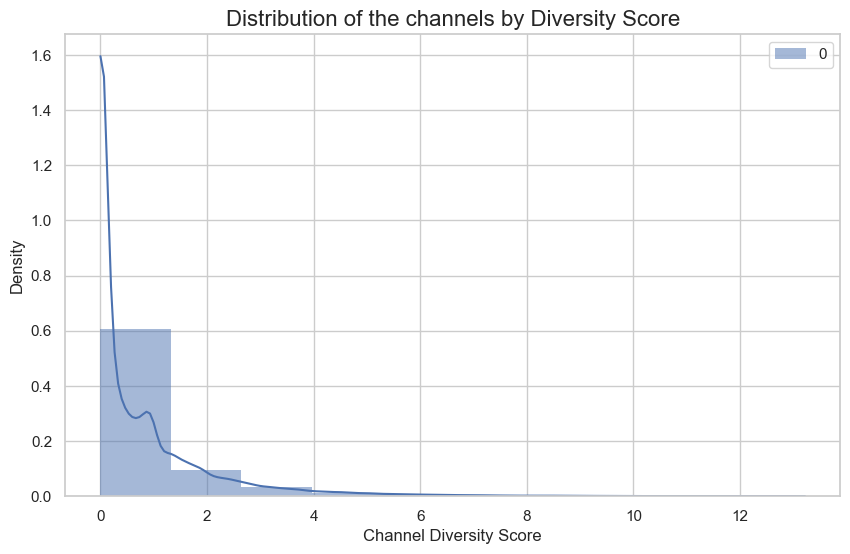

In [13]:
# Distribution of the channels by Diversity Score
plot_generation.plot_distribution(diversity_scores_distribution.values(),"Distribution of the channels by Diversity Score","Channel Diversity Score")

From the histogram of channel frequencies and their corresponding diversity scores, we observe that several potential generative laws could explain the observed distribution. The distribution could follow one of the following forms:

1. **Exponential Distribution**: The probability density function (PDF) is given by:

   $$
   f(x|\lambda) = \lambda e^{-\lambda x}, \quad x \geq 0
   $$

2. **Truncated Normal Distribution**: A normal distribution restricted to a specific range, typically used when data is confined within certain bounds. The truncated normal PDF is:

   $$
   f(x|\mu, \sigma, a, b) = \frac{\phi\left(\frac{x - \mu}{\sigma}\right)}{\sigma[\Phi\left(\frac{b - \mu}{\sigma}\right) - \Phi\left(\frac{a - \mu}{\sigma}\right)]}, \quad a \leq x \leq b
   $$

   where $\phi$ is the standard normal PDF and $\Phi$ is the cumulative distribution function (CDF).

3. **Gamma Distribution**:

   $$
   f(x|\alpha, \beta) = \frac{x^{\alpha-1} e^{-x/\beta}}{\beta^\alpha \Gamma(\alpha)}, \quad x \geq 0
   $$

4. **Beta Distribution**:

   $$
   f(x|\alpha, \beta) = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha, \beta)}, \quad 0 \leq x \leq 1
   $$

To determine which of these distributions is most plausible for our diversity score data, we proceed by analyzing their goodness of fit. The first step in this process is to visualize the data against the theoretical distribution using a **Quantile-Quantile (QQ) plot**: A QQ plot compares the quantiles of the empirical data against the quantiles of a given theoretical distribution. If the data follows the proposed distribution, the points in the QQ plot will lie approximately on a straight line.

C:\Users\haoul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_continuous_distns.py:719: RuntimeWarning:

invalid value encountered in sqrt



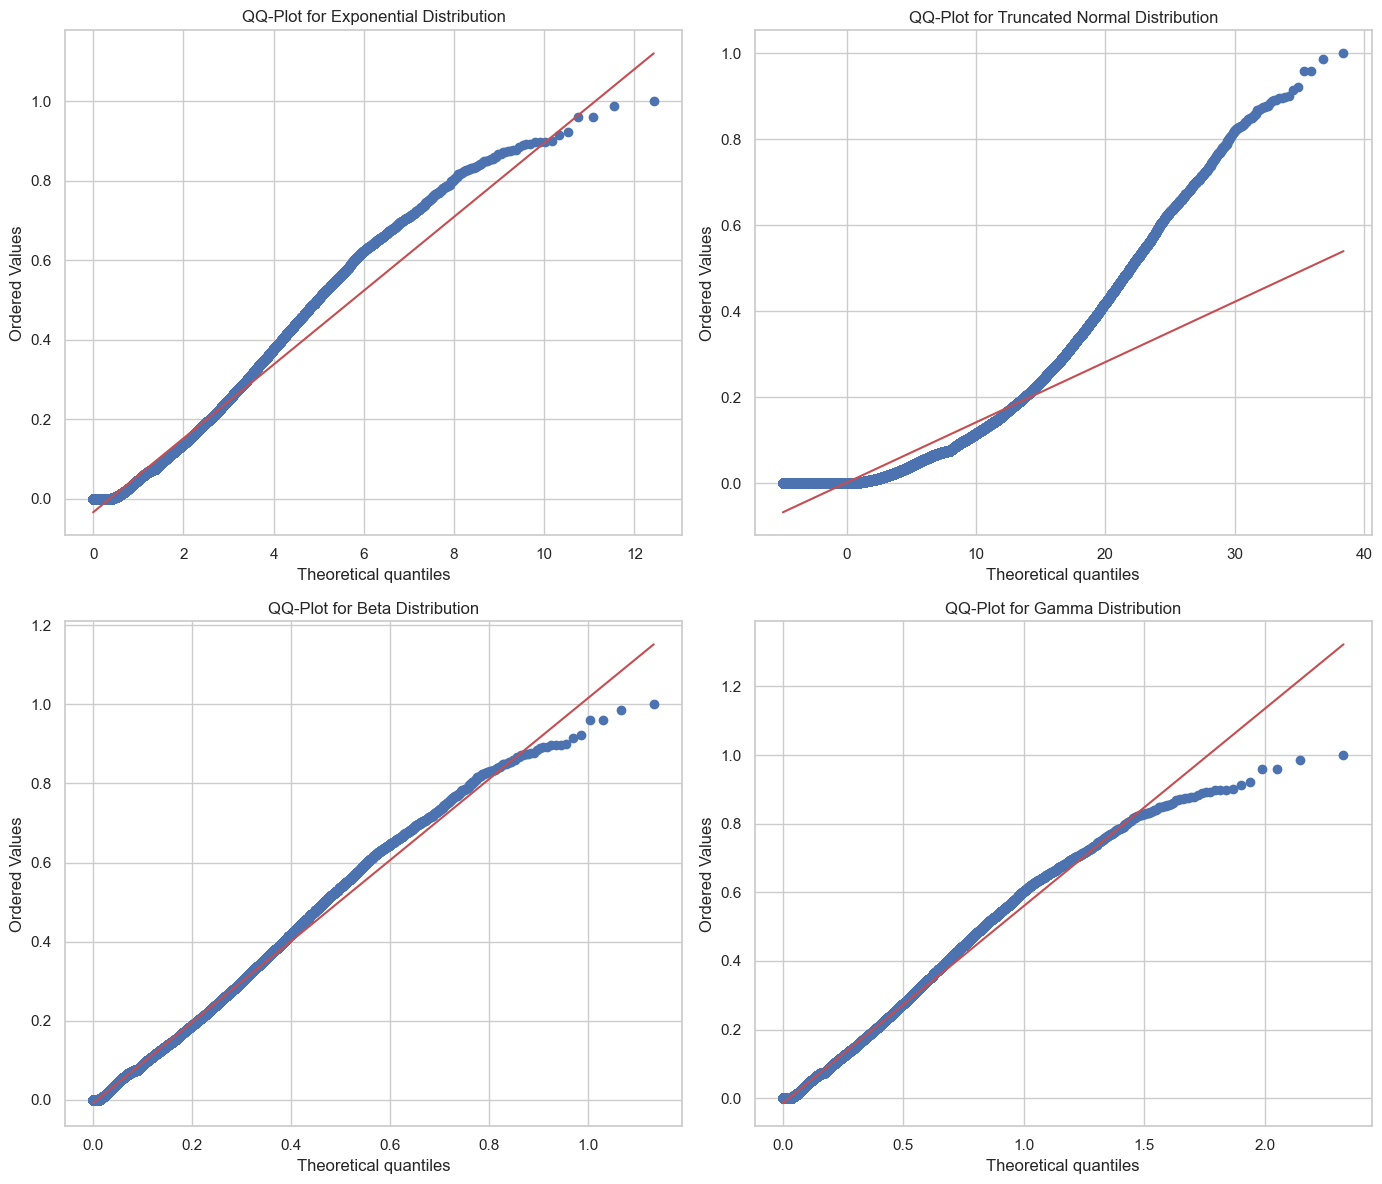

In [14]:
# QQ-plots
plot_generation.qq_plots(diversity_scores_distribution.values())

Upon examining the Q-Q plots for each candidate distribution, it becomes evident that the gamma and beta distributions are the most plausible candidates for the true generative model. This observation highlights the limitations of relying solely on visual inspection to determine a sample's underlying distribution. While initial examination of distribution plots suggested that the exponential and truncated normal distributions were strong contenders, the Q-Q plots reveal significant deviations, indicating that these distributions are less likely to fit the data accurately.

To further solidify our conclusions, we will now compute both the log-likelihood and the mean squared error (MSE) of the Q-Q plots. These quantitative measures will help us determine, with greater confidence, which distribution best fits the observed data.

In [15]:
# Method that computes the mean squared error between quantiles
def qq_mse(data, theoretical_dist, params=()):
    """Calculate the MSE between observed and theoretical quantiles for a given distribution."""
    quantiles, expected = stats.probplot(data, dist=theoretical_dist, sparams=params)[0]
    mse = np.mean((quantiles - expected) ** 2)
    return mse

# Method that computes the log-likelihood and the qq_mse for each one of our candidate distribution
def calculate_metrics(data):
    # Normalize the data to [0, 1] range for fair comparison
    data_scaled = (data - np.min(data)) / (np.max(data) - np.min(data))

    metrics = {}

    # 1. Exponential Distribution
    params_expon = stats.expon.fit(data_scaled)
    loglik_expon = np.sum(stats.expon.logpdf(data_scaled, *params_expon))
    mse_expon = qq_mse(data_scaled, 'expon', params_expon)
    metrics['Exponential'] = {'Log-Likelihood': loglik_expon, 'QQ MSE': mse_expon}

    # 2. Truncated Normal Distribution
    a, b = (min(data_scaled) - np.mean(data_scaled)) / np.std(data_scaled), (max(data_scaled) - np.mean(data_scaled)) / np.std(data_scaled)
    loc, scale = np.mean(data_scaled), np.std(data_scaled)
    params_truncnorm = (a, b, loc, scale)
    loglik_truncnorm = np.sum(stats.truncnorm.logpdf(data_scaled, a, b, loc, scale))
    mse_truncnorm = qq_mse(data_scaled, 'truncnorm', params_truncnorm)
    metrics['Truncated Normal'] = {'Log-Likelihood': loglik_truncnorm, 'QQ MSE': mse_truncnorm}

    # 3. Beta Distribution (requires scaling data to [0, 1])
    params_beta = stats.beta.fit(data_scaled)
    loglik_beta = np.sum(stats.beta.logpdf(data_scaled, *params_beta))
    mse_beta = qq_mse(data_scaled, 'beta', params_beta)
    metrics['Beta'] = {'Log-Likelihood': loglik_beta, 'QQ MSE': mse_beta}

    # 4. Gamma Distribution
    params_gamma = stats.gamma.fit(data_scaled)
    loglik_gamma = np.sum(stats.gamma.logpdf(data_scaled, *params_gamma))
    mse_gamma = qq_mse(data_scaled, 'gamma', params_gamma)
    metrics['Gamma'] = {'Log-Likelihood': loglik_gamma, 'QQ MSE': mse_gamma}

    return pd.DataFrame(metrics).T

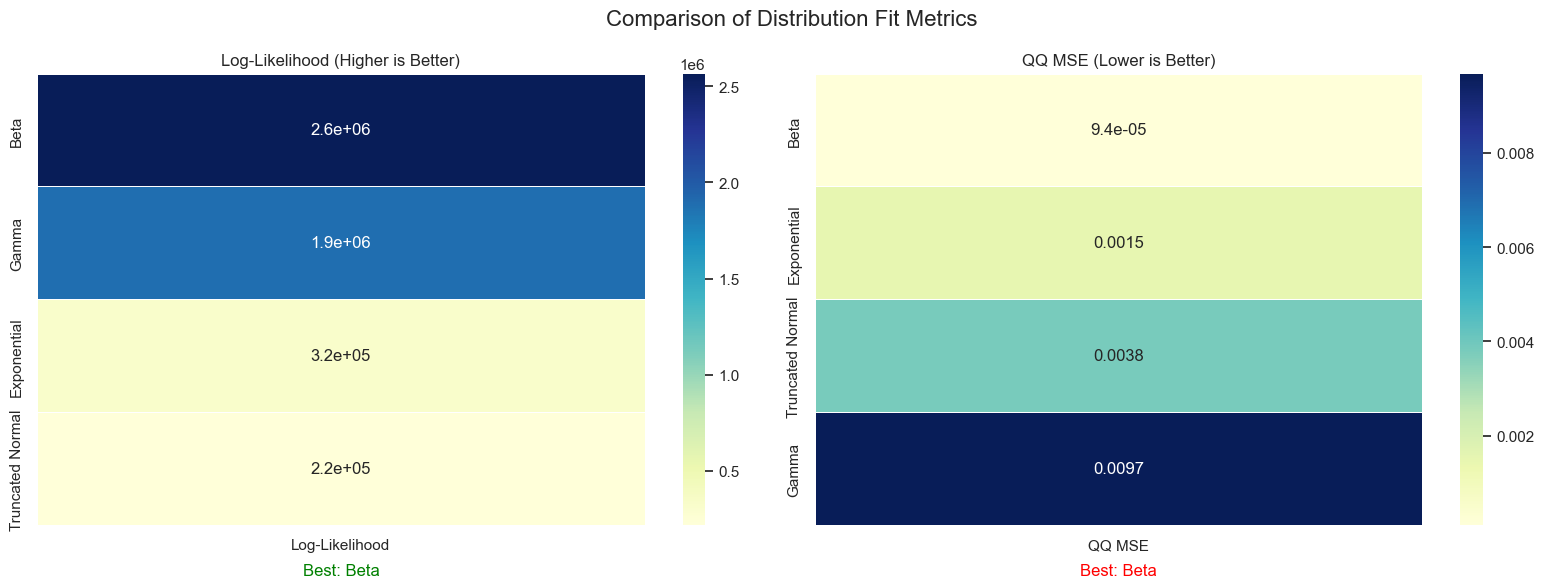

In [16]:
# Results!!
df_metrics = calculate_metrics(np.array(list(diversity_scores_distribution.values())))
plot_generation.plot_metrics_data(df_metrics)

The fact that YouTube channel diversity scores follow a Beta distribution implies that most channels tend to focus on a narrow set of categories, resulting in low diversity scores. This indicates that many creators prefer specialized content strategies, sticking to a limited range of topics. The flexibility of the Beta distribution also suggests that while some channels embrace broader content diversity, the majority operate within a more restrictive set of categories, reflecting strategic choices for niche targeting or audience consistency.

By identifying the true generative law, we can make afterwards more accurate predictions about a channel's future diversity scores. This understanding enables us to model the relationship between content strategy and diversity, allowing for better forecasting of how changes in content focus might impact a channel's diversity over time. It also provides a foundation for identifying trends and anomalies in content categorization across different channels.

## 3. Inspecting optimal diversity domains

In order to explore the relationship between channel diversity and success, we aim to divide the diversity domain into three distinct categories: **low, moderate, and high diversity**. This approach will help us identify whether certain levels of content diversity are correlated with greater **channel success**. To ensure that our findings are **not overly reliant on specific data subsets** and can be generalized across different types of channels, we will use the theoretical quantiles of the Beta distribution to define these categories. By leveraging these quantiles, we can create **well-balanced groups** based on the natural spread of the diversity scores, ensuring statistical rigor and minimizing any bias that might arise from arbitrary cutoffs.

Furthermore, by constructing balanced domains, we can ensure that each category has an adequate representation of channels, which will allow us to draw meaningful, statistically significant conclusions about how diversity levels affect channel success. This method helps avoid overfitting to specific trends in the data, leading to more robust, generalizable insights.

In [38]:
# Retrieve channel data collection
channel_data_collection = db_connection.connect_to_mongodb("Channel Data")

Connected to MongoDB at localhost:27017, Database: evollistable, Collection: Channel Data


In [39]:
def categorize_channels_by_diversity(results, low_quantile_order, high_quantile_order):
    """
    Categorize YouTube channels based on diversity scores into low, moderate, and high categories,
    assuming the generative law is Beta distribution.

    Parameters:
    - results (dict): A dictionary where keys are channel_ids and values are diversity scores.

    Returns:
    - dict: A dictionary with 'low', 'moderate', and 'high' categories, where each category
            contains a list of channel_ids.
    """
    # Extract the diversity scores from the results dictionary
    diversity_scores = list(results.values())

    # Normalize the data to [0, 1] range
    min_value = np.min(diversity_scores)
    max_value = np.max(diversity_scores)
    normalized_data = (diversity_scores - min_value) / (max_value - min_value)

    # Fit the Beta distribution to the normalized data
    alpha, beta, loc, scale = stats.beta.fit(normalized_data)  # fit to scaled data

    # Compute the quantiles for categorization
    low_quantile = stats.beta.ppf(low_quantile_order, alpha, beta, loc, scale)
    high_quantile = stats.beta.ppf(high_quantile_order, alpha, beta, loc, scale)

    # Create the categories dictionary
    categories = {'low': [], 'moderate': [], 'high': []}

    # Assign channels to categories based on their normalized diversity scores
    for channel_id, score in results.items():
        # Normalize the score
        normalized_score = (score - min_value) / (max_value - min_value)

        # Categorize the channels
        if normalized_score <= low_quantile:
            categories['low'].append(channel_id)
        elif normalized_score <= high_quantile:
            categories['moderate'].append(channel_id)
        else:
            categories['high'].append(channel_id)

    return categories

**i. Example**

We begin by dividing the diversity domain into three categories using $q_1=0.1$ and $q_2=0.2$, ensuring a balanced distribution across categories. Next, we will examine whether these diversity categories have an impact on subscriber count.

In [ ]:
# Retrieve the subscribers for each category
channel_cats = categorize_channels_by_diversity(diversity_scores_distribution, 0.1,0.6)
subscribers_dict = db_methods.retrieve_subscribers_for_categories(channel_cats, channel_data_collection)

C:\Users\haoul\AppData\Local\Temp\ipykernel_48048\359731162.py:33: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




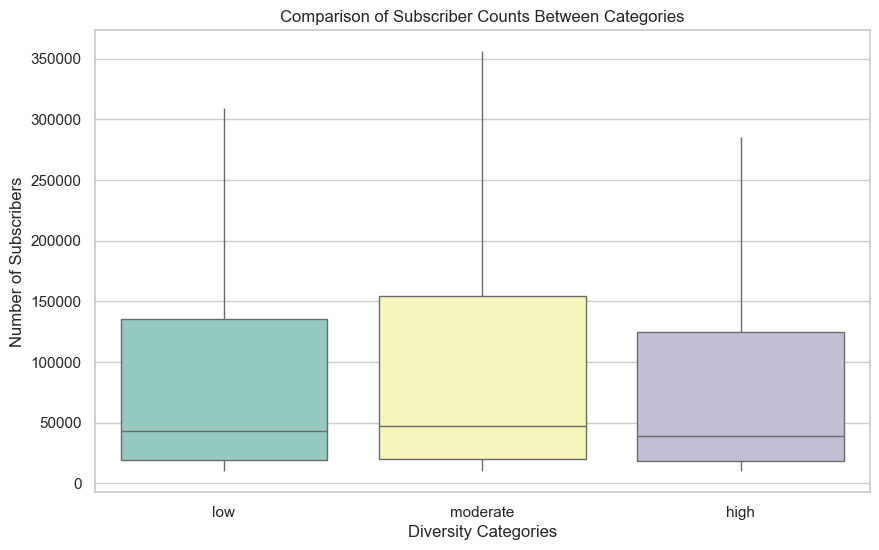

In [ ]:
# Plot the comparison
plot_generation.plot_subscribers_comparison_with_boxes(subscribers_dict)

From the initial plot, it appears that there is a significant difference in the number of subscribers across the three diversity categories. However, as emphasized earlier, **visual inspection alone is not sufficient to draw reliable conclusions**. To rigorously support our claim, we will apply non-parametric statistical tests to assess whether the observed differences are statistically significant.

To test for differences between the three diversity categories, we will use the **Kruskal-Wallis test**. This test is appropriate because it does not assume a normal distribution of the data and can compare more than two groups. The null hypothesis for this test is that all groups have the same distribution, while the alternative hypothesis is that at least one group differs significantly from the others.

We will proceed with pairwise comparisons using the **Mann-Whitney U test**. This test will allow us to compare each pair of diversity categories to identify which specific groups differ from each other. The Mann-Whitney U test is a non-parametric test that compares the ranks of two independent groups, with the null hypothesis being that the two groups come from the same distribution.

In [21]:
def compare_subscriber_distributions(subscribers_dict):
    """
    Perform pairwise comparisons between categories using the Kruskal-Wallis test
    and the Mann-Whitney U test with manual Bonferroni correction.

    Parameters:
    - subscribers_dict: A dictionary with three keys ('low', 'moderate', 'high')
                        containing lists of subscriber counts for each category.
    """
    # Extract subscriber data
    low = subscribers_dict['low']
    moderate = subscribers_dict['moderate']
    high = subscribers_dict['high']

    # Step 1: Kruskal-Wallis Test (overall test)
    stat, p_value = kruskal(low, moderate, high)
    print(f"Kruskal-Wallis Test statistic: {stat}, p-value: {p_value}")

    if p_value < 0.05:
        print("\nThere is a significant difference between the categories.")

        # Step 2: Pairwise Mann-Whitney U Tests
        comparisons = [
            ('low', 'moderate', low, moderate),
            ('low', 'high', low, high),
            ('moderate', 'high', moderate, high)
        ]

        p_values = []
        results = []

        print("\nPerforming pairwise Mann-Whitney U tests:")
        for name1, name2, group1, group2 in comparisons:
            stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
            p_values.append(p)
            results.append((name1, name2, stat, p))

        # Step 3: Manual Bonferroni Correction
        num_comparisons = len(comparisons)
        corrected_p_values = [min(p * num_comparisons, 1.0) for p in p_values]  # Bonferroni correction

        # Display the results
        print("\nPairwise comparisons with Bonferroni correction:")
        for (name1, name2, stat, original_p), corrected_p in zip(results, corrected_p_values):
            print(f"Comparison: {name1} vs {name2}")
            print(f"  Mann-Whitney U statistic: {stat}, Original p-value: {original_p}, Corrected p-value: {corrected_p}")
            if corrected_p < 0.05:
                print("  Significant difference between groups.\n")
            else:
                print("  No significant difference between groups.\n")
    else:
        print("No significant difference between the categories.")

In [ ]:
compare_subscriber_distributions(subscribers_dict)

Kruskal-Wallis Test statistic: 310.85234368643364, p-value: 3.156975599017611e-68

There is a significant difference between the categories.

Performing pairwise Mann-Whitney U tests:

Pairwise comparisons with Bonferroni correction:
Comparison: low vs moderate
  Mann-Whitney U statistic: 804346701.0, Original p-value: 5.0161500340503645e-18, Corrected p-value: 1.5048450102151094e-17
  Significant difference between groups.

Comparison: low vs high
  Mann-Whitney U statistic: 1140711960.0, Original p-value: 7.237358189751687e-17, Corrected p-value: 2.1712074569255058e-16
  Significant difference between groups.

Comparison: moderate vs high
  Mann-Whitney U statistic: 1206832607.5, Original p-value: 3.9207767057085684e-69, Corrected p-value: 1.1762330117125705e-68
  Significant difference between groups.



**ii. Identifying the Optimal Diversity Region**

Now that we have established statistical significance regarding the differences in subscription distributions across the three diversity categories, we aim to identify the optimal diversity region for channel success. To do this, we will perform a grid search across different quantile values for $q_1$ and $q_2$, which define the boundaries of the diversity categories.

The grid search will be constrained by the requirement to maintain fairly balanced categories. Specifically:

- When $q_1 = 0$ or $q_2 = 1$, we will limit the search to two categories, ensuring they are balanced (dividing the diversity domain into a low and high diversity category).
- Otherwise, for intermediate values of $q_1$ and $q_2$, we will examine three balanced categories, each representing a distinct diversity level (low, moderate, and high).


C:\Users\haoul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_continuous_distns.py:719: RuntimeWarning:

invalid value encountered in sqrt



Best Quantiles Found: q1 = 0.05, q2 = 0.6, Mean Subscribers = 281665.5641787497


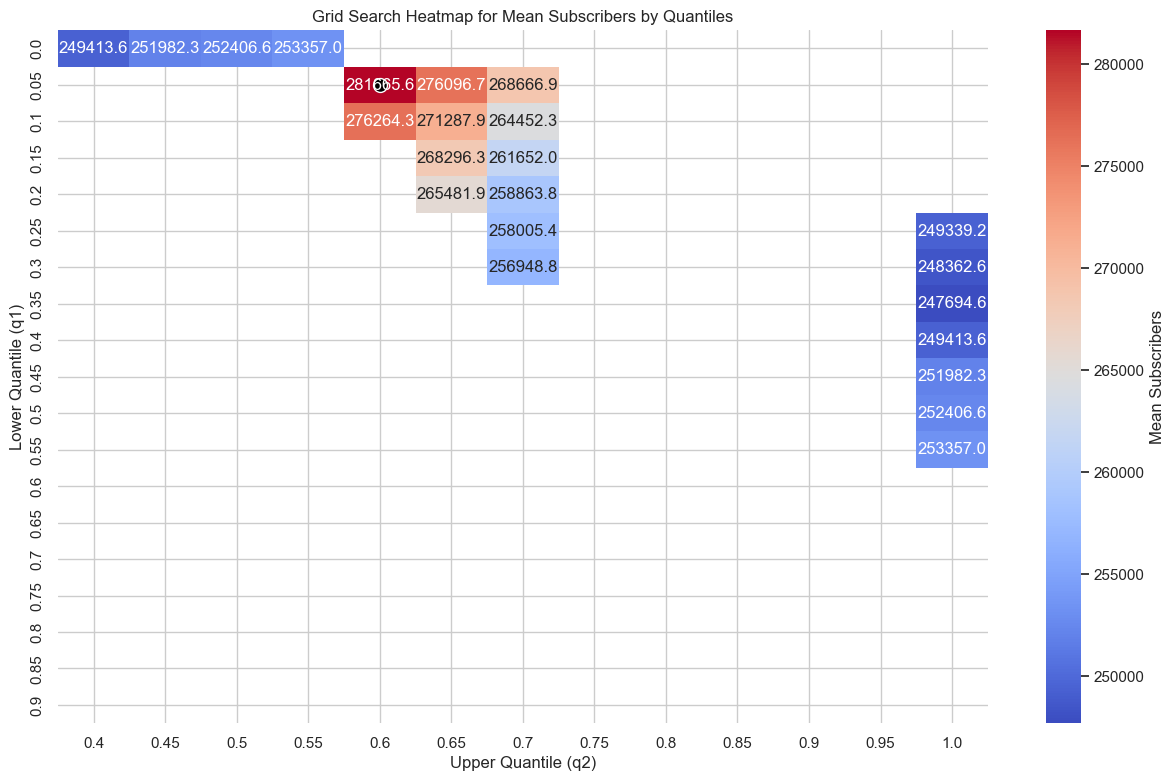

In [ ]:
def visualize_grid_search(results, collection, q1_range, q2_range, min_balance=0.3):
    """
    Visualize the results of the grid search as a heatmap.

    Parameters:
    - results: The dictionary of diversity scores per channel.
    - collection: The MongoDB collection to fetch subscriber data.
    - q1_range: List or numpy array of quantiles for the lower boundary.
    - q2_range: List or numpy array of quantiles for the upper boundary.
    - min_balance: Minimum proportion of channels required in each category.
    """
    heatmap_data = np.full((len(q1_range), len(q2_range)), np.nan)
    n_total = len(results)
    best_q1, best_q2 = None, None
    best_mean_subscribers = -np.inf

    for i, q1 in enumerate(q1_range):
        for j, q2 in enumerate(q2_range):
            if q2 <= q1:
                continue

            # Special case: if q1 == 0, use two categories
            if q1 == 0:
                categories = categorize_channels_by_diversity(results, q1, q2)
                size_low = len(categories['moderate'])
                size_high = len(categories['high'])
                new_min_balance = 0.4

                if size_low / n_total >= new_min_balance and size_high / n_total >= new_min_balance:
                    subscribers_dict = db_methods.retrieve_subscribers_for_categories(categories, collection)
                    mean_subscribers_moderate = np.mean(subscribers_dict['moderate']) if subscribers_dict['moderate'] else 0
                    mean_subscribers_high = np.mean(subscribers_dict['high']) if subscribers_dict['high'] else 0
                    max_mean_subscribers = max(mean_subscribers_moderate, mean_subscribers_high)

                    heatmap_data[i, j] = max_mean_subscribers

                    if max_mean_subscribers > best_mean_subscribers:
                        best_mean_subscribers = max_mean_subscribers
                        best_q1, best_q2 = q1, q2

            if q2 == 1:
                categories = categorize_channels_by_diversity(results, q1, q2)
                size_low = len(categories['low'])
                size_moderate = len(categories['moderate'])
                new_min_balance = 0.4

                if size_low / n_total >= new_min_balance and size_moderate / n_total >= new_min_balance:
                    subscribers_dict = db_methods.retrieve_subscribers_for_categories(categories, collection)
                    mean_subscribers_low = np.mean(subscribers_dict['low']) if subscribers_dict['low'] else 0
                    mean_subscribers_moderate = np.mean(subscribers_dict['moderate']) if subscribers_dict['moderate'] else 0
                    max_mean_subscribers = max(mean_subscribers_low, mean_subscribers_moderate)

                    heatmap_data[i, j] = max_mean_subscribers

                    if max_mean_subscribers > best_mean_subscribers:
                        best_mean_subscribers = max_mean_subscribers
                        best_q1, best_q2 = q1, q2

            else:
                # Handle three-category case
                categories = categorize_channels_by_diversity(results, q1, q2)
                size_low = len(categories['low'])
                size_moderate = len(categories['moderate'])
                size_high = len(categories['high'])

                if (size_low / n_total >= min_balance and
                    size_moderate / n_total >= min_balance and
                    size_high / n_total >= min_balance):

                    subscribers_dict = db_methods.retrieve_subscribers_for_categories(categories, collection)
                    if subscribers_dict['moderate']:
                        mean_subscribers_moderate = np.mean(subscribers_dict['moderate'])
                        heatmap_data[i, j] = mean_subscribers_moderate

                        if mean_subscribers_moderate > best_mean_subscribers:
                            best_mean_subscribers = mean_subscribers_moderate
                            best_q1, best_q2 = q1, q2

    print(f"Best Quantiles Found: q1 = {best_q1}, q2 = {best_q2}, Mean Subscribers = {best_mean_subscribers}")

    # Plotting the heatmap
    plt.figure(figsize=(15, 9))
    sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm",
                xticklabels=np.round(q2_range, 2), yticklabels=np.round(q1_range, 2),
                cbar_kws={'label': 'Mean Subscribers'})

    plt.title("Grid Search Heatmap for Mean Subscribers by Quantiles")
    plt.xlabel("Upper Quantile (q2)")
    plt.ylabel("Lower Quantile (q1)")

    # Highlight the optimal point
    if best_q1 is not None and best_q2 is not None:
        optimal_i = np.where(q1_range == best_q1)[0][0]
        optimal_j = np.where(q2_range == best_q2)[0][0]
        plt.scatter(optimal_j + 0.5, optimal_i + 0.5, color='black', s=100, edgecolors='white', marker='o')

    plt.show()

# Results
# Define the range of quantiles to test
q1_range = np.linspace(0, 0.9, 19)
q2_range = np.linspace(0.4, 1.0, 13)

# Visualize the grid search results
visualize_grid_search(diversity_scores_distribution, channel_data_collection, q1_range, q2_range, min_balance=0.27)

From our analysis, it appears that the optimal domain for maximizing subscription counts lies within the moderate diversity category, defined by the quantile values $𝑞_1=0.05$ and $𝑞_1=0.6$. This domain seems to strike a balance between channels that focus too narrowly on a small set of categories (low diversity) and those that attempt to cover too many topics (high diversity).

Channels within this moderate diversity range likely benefit from a combination of the following factors:

+ Targeted Content Strategy: Channels that operate within this domain may be focusing on a **broad but still manageable range of topics**. They are not too specialized to limit their audience, nor are they too generalized to lose focus. This balance may help attract a more consistent and engaged subscriber base.

+ Audience Engagement: Channels that span a moderate number of categories can cater to a variety of viewer interests, leading to increased engagement. At the same time, they avoid spreading themselves too thin across unrelated topics, which could dilute the channel's identity and cause audience fragmentation.

+ Content Differentiation: By staying within the moderate diversity range, these channels are likely to stand out in niche areas without competing with the most generalized or overly specific content. This positioning could lead to higher discoverability and a greater likelihood of attracting subscribers who are interested in a curated but diverse set of topics.

+ Statistical Support: The significant differences in subscription counts observed within this moderate diversity range, as confirmed by statistical tests, suggest that the choice of content breadth within this domain positively influences channel growth. This is likely due to the fact that it aligns with a larger, more engaged audience while still maintaining a distinct channel identity.

**Remark**

We plan to extend this analysis to other key metrics, including viewership, likes, and the number of comments. By examining how these metrics relate to different diversity domains, we aim to gain a more comprehensive understanding of how content diversity impacts not only subscriber growth but also overall engagement and interaction across YouTube channels.

# III. Comparing the evolution of channels accross clusters

**Motivation**

In this analysis, we aim to understand and compare the growth dynamics of different categories of YouTube channels. Specifically, we are interested in evaluating how channels in categories like "Gaming ,Music and Films" compare to those in more educational categories, such as "Education & How-to", over time. Our goal is to study and visualize the growth rates, trends, and patterns in viewership and subscription across these categories to identify key differences in their typical growth trajectories.

Given the large volume of data (millions of documents), we made a deliberate choice to utilize hashmaps instead of pandas DataFrames for most of the data processing. While DataFrames are powerful tools for data manipulation, they can be slower and more memory-intensive when dealing with extremely large datasets. By using maps, we achieve faster retrieval and transformation of our data, making our analysis more efficient and scalable.

**1. Data retrieval from MongoDB**

We start first by retrieving the time series data of the top 5000 channels for each one of our clusters of interest.

In [25]:
# MongoDB connection
channels_weekly_time_series = db_connection.connect_to_mongodb("Channels Weekly Time Series")

Connected to MongoDB at localhost:27017, Database: evollistable, Collection: Channels Weekly Time Series


In [27]:
# First Cluster
cluster1 = ["Gaming","Music","Film and Animation", "Comedy"]
cluster1_data = db_methods.retrieve_timeseries_data_by_cluster(channels_weekly_time_series, cluster1)

Retrieved the list of the top 5000 channels.
Fetched time series data.
Converted strings to datetime objects


In [29]:
# Second Cluster
cluster2 = ["Education", "Howto & Style", "Science & Technology"]
cluster2_data = db_methods.retrieve_timeseries_data_by_cluster(channels_weekly_time_series, cluster2)

Retrieved the list of the top 5000 channels.
Fetched time series data.
Converted strings to datetime objects


**2. Computing Growth Rates**

Before delving into the analysis of the data, we need to compute the growth rate of views for each channel. These growth rates will helps us understand how fast a channel is growing in terms of its viewership/subscription over time. The formula we use to calculate the growth rate between two consecutive time periods is as follows:

$$
\text{Growth Rate} (\%) = \left(\frac{\text{current value} - \text{previous value}}{\text{previous value}}\right) \times 100
$$

In [30]:
def calculate_growth_ratios(data):
    """
    Computes growth ratios for views and subscribers.
    """
    data_copy = data
    for channel_id, group in data_copy.items():
        prev_views, prev_subs, prev_videos = None, None, None
        for entry in group:
            if prev_views is not None and prev_subs is not None and prev_videos is not None:
                entry['growth_views'] = (entry['views'] - prev_views) / prev_views * 100 if prev_views > 0 else 0
                entry['growth_subs'] = (entry['subs'] - prev_subs) / prev_subs * 100 if prev_subs > 0 else 0

            else:
                entry['growth_views'] = 0
                entry['growth_subs'] = 0
            prev_views, prev_subs, prev_videos = entry['views'], entry['subs'], entry['videos']
    return data_copy

In [31]:
# Calculate growth ratios for both clusters
growth_data1 = calculate_growth_ratios(cluster1_data)
growth_data2 = calculate_growth_ratios(cluster2_data)

**3. Aligning the Time Series Data**

Given that channels are created at different times, their time series data are naturally misaligned. For a meaningful comparison, it’s crucial to align the time series data such that the starting point corresponds to the same relative timeline for all channels. This alignment will be done by transforming the original timestamps into a unified "aligned week" metric, where the first week of each channel's data starts at week zero. By aligning channels in this way, we can compare how channels grow relative to their own inception, making our analysis more coherent across different categories.

To achieve this, we will adjust each channel's timestamps into an aligned week format, allowing us to compare growth trends based on a common timeline.

In [32]:
def align_time_series(data):
    """
    Aligns time series data for channels by shifting each channel to start from week 0.
    """
    aligned_data = defaultdict(list)
    for channel_id, entries in data.items():
        entries = sorted(entries, key=lambda x: x['datetime'])
        start_date = entries[0]['datetime']
        for entry in entries:
            entry['aligned_week'] = (entry['datetime'] - start_date).days // 7
            aligned_data[channel_id].append(entry)
    return aligned_data

In [33]:
# Time Series data Alignment
aligned_cluster1 = align_time_series(growth_data1)
aligned_cluster2 = align_time_series(growth_data2)

**4. Smoothing the data**

To obtain a clearer picture of the underlying growth trend, we will smooth the data using a rolling average. This smoothing process helps to reduce the noise by averaging the growth rates over a fixed window, making the trends more stable and interpretable.

In [34]:
def smooth_data(data, window=2):
    """
    Applies moving average smoothing to growth ratios.
    """
    for channel_id, entries in data.items():
        df = pd.DataFrame(entries)
        df['smoothed_views'] = df['growth_views'].rolling(window=window, min_periods=1).mean()
        df['smoothed_subs'] = df['growth_subs'].rolling(window=window, min_periods=1).mean()

        data[channel_id] = df.to_dict(orient='records')
    return data

In [35]:
# Smoothing
smoothed_data1 = smooth_data(aligned_cluster1)
smoothed_data2 = smooth_data(aligned_cluster2)

**5. Results time!**

**5.1. Viewership Comparison in short-term (1st year)**

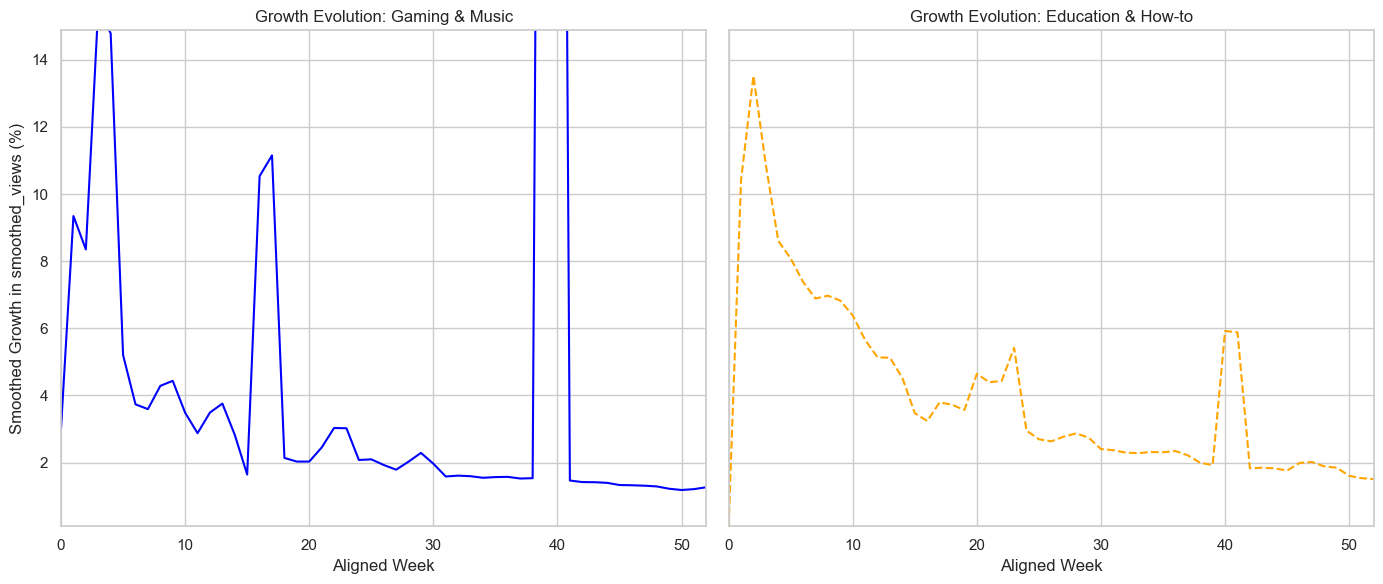

In [36]:
plot_generation.plot_mean_growth_comparison(
    'smoothed_views',
    smoothed_data1,
    smoothed_data2,
    'Gaming & Music',
    'Education & How-to',
    xlim_start=0,
    xlim_end=52
)

In the short term (within the first year after a channel’s creation), we observe a pronounced difference in growth patterns between the two clusters. For entertainment-focused channels , there is a clear pattern of **intense variations** in growth rates after certain triggering events. These events may be tied to the release of new videos, which often result in a sudden spike in viewership followed by a sharp decline.

This can be explained by the nature of entertainment content:

+ **Immediate Popularity and Trends:** Entertainment videos tend to gain significant traction almost immediately after release. This is often due to trending topics, popular culture relevance, or promotional efforts that create a surge in views shortly after publication. However, the interest can decline just as rapidly once the content is no longer trending, leading to an intense decrease or even a vanishing effect.
+ **Short Attention Span of Audiences:** Entertainment content often caters to a wide but short-lived attention span, leading to large spikes and drops in engagement metrics.

On the other hand, for education-oriented channels, the growth pattern is less volatile. There are fewer sharp increases or decreases, indicating a more steady and sustained level of interest in the content over time. This is likely due to several factors:

+ **Evergreen Content:** Educational videos are typically less time-sensitive and provide long-term value. Viewers may return to these videos months or even years after their release, contributing to a more stable growth pattern.
+ **Longer Shelf Life:** Unlike entertainment content that can quickly become outdated, educational videos often have longer-lasting relevance, which helps maintain consistent viewership growth.

Thus, the first cluster shows more intense but ephemeral engagement, while the second cluster exhibits a more gradual and sustained pattern of viewership growth.

**Subscription Growth Comparison in short term (1st year)**

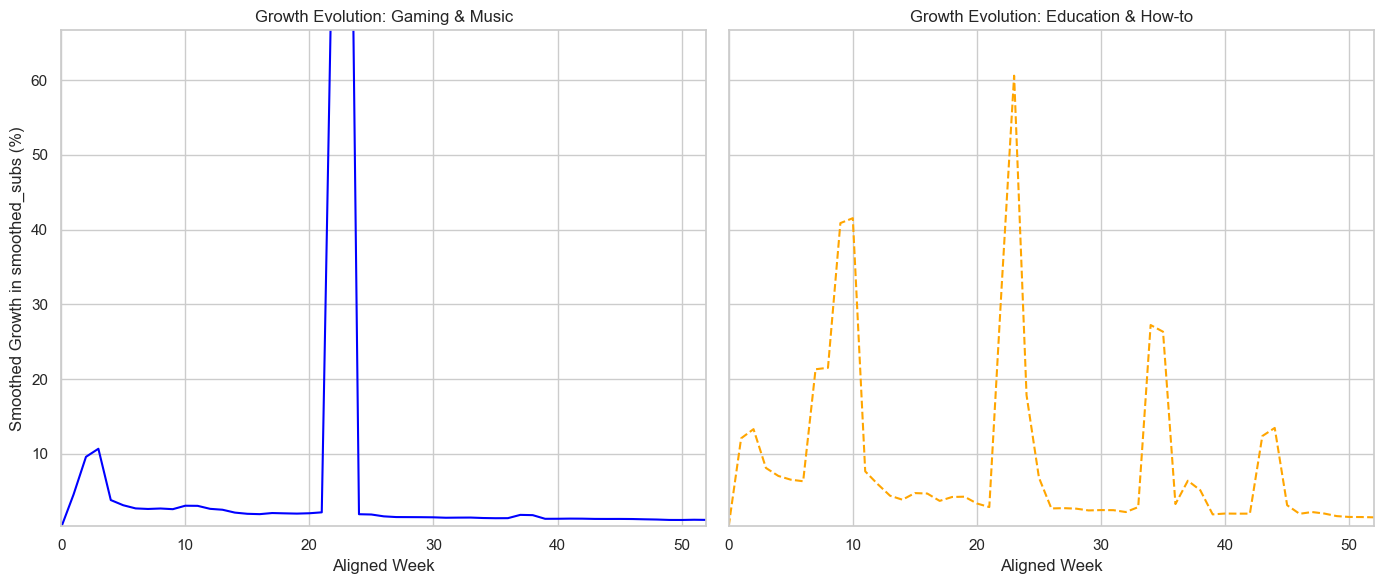

In [37]:
plot_generation.plot_mean_growth_comparison(
    'smoothed_subs',
    smoothed_data1,
    smoothed_data2,
    'Gaming & Music',
    'Education & How-to',
    xlim_start=0,
    xlim_end=52
)

When comparing the growth in subscribers between the two clusters, we observe distinct differences in patterns:

+ **Entertainment Cluster:**

For the first cluster, **the subscription growth tends to show sharp spikes**, often corresponding to a viral video release, a highly successful content drop or to an external factor. However, these spikes are followed by a rapid stabilization or even a decline in the rate of new subscriptions.

**Explanation:** Once a video in the entertainment category goes viral, channels experience a surge in new subscribers as viewers want to keep up with similar content. However, after the initial spike, growth stagnates because the core audience interested in this type of content has already subscribed. Additionally, if the channel doesn’t release similarly engaging content afterward, the growth rate may diminish quickly.
+ **Education-Oriented Cluster:**

In contrast, the second cluster displays a **more cyclical or periodic pattern in terms of subscriber growth**. This cluster exhibits smaller, more consistent increases over time, with less pronounced peaks.

**Explanation:** Educational channels do not experience the same viral spikes as entertainment channels. Instead, they grow gradually as they reach new audiences looking for specific, informative content. The growth here is more organic, driven by the consistent value provided over time. **The cyclical nature may be attributed to the seasonal demand for educational content (e.g., school semesters, exam periods)** or new content updates that attract periodic interest. The decrease in subscriber growth for these channels tends to be much slower. Unlike entertainment channels, which might lose subscribers due to changing trends, educational channels retain subscribers because the value of their content remains relevant. However, a slow decline in growth can occur as channels face competition from newer content or suffer from periods of inactivity.